In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import os

## Load Data

In [37]:
dtp = pd.read_csv(os.path.join('data', 'VN_DTP_cross_tlight_stops_bump.csv'), encoding='utf-8', sep=',')
dtp['target'] = 1
#dtp = dtp.rename(columns={"X": "bump_Dista", "Y": "bump_Distance"})
dtp.shape

(3073, 43)

In [38]:
dtp.columns

Index(['Дата', 'Время', 'Место', 'Улица', 'Дом', 'Адрес', 'Дорог', 'Килом',
       'Метр', 'Full Addre', 'Latitude', 'Longitude', 'Погиб', 'Поги_1',
       'Ранен', 'Ране_1', 'join_id', 'join_@id', 'join_area', 'join_highw',
       'join_surfa', 'join_int_r', 'join_lanes', 'join_maxsp', 'join_max_1',
       'join_onewa', 'join_ref', 'join_name', 'join_snowp', 'join_descr',
       'join_smoot', 'join_troll', 'join_width', 'DTP_ID', 'Crossing_T',
       'Crossing_D', 'Traf_light', 'Traf_lig_1', 'stops_Targ', 'stops_Dist',
       'bump_Targe', 'bump_Dista', 'target'],
      dtype='object')

In [39]:
dtp[(dtp['Погиб']>0)|(dtp['Ранен']>0)|(dtp['Ране_1']>0)].shape

(342, 43)

In [40]:
#dtp = dtp[(dtp['Погиб']>0)|(dtp['Ранен']>0)|(dtp['Ране_1']>0)]
#dtp.shape

In [41]:
no_dtp = pd.read_csv(os.path.join('data', 'VN_rpoints_cross_tlight_stops_bump_COORD.csv'), encoding='utf-8', sep=',')
no_dtp['target'] = 0
no_dtp.shape
#Удалим, если на расстоянии 50 метров были смертельные ДТП и если на расстоянии 10 метров были вообще ДТП
no_dtp = no_dtp[(no_dtp['Num_50Deat']==0)&(no_dtp['NUM_10NOND']==0)]
no_dtp = no_dtp.rename(columns={"X": "Longitude", "Y": "Latitude"})

In [42]:
same_cols = set(no_dtp.columns).intersection(dtp.columns)
same_cols.difference_update(['join_max_1','join_area','join_int_r'])

In [43]:
same_cols

{'Crossing_D',
 'Crossing_T',
 'Latitude',
 'Longitude',
 'Traf_lig_1',
 'Traf_light',
 'bump_Dista',
 'bump_Targe',
 'join_@id',
 'join_highw',
 'join_id',
 'join_lanes',
 'join_maxsp',
 'join_name',
 'join_onewa',
 'join_ref',
 'join_surfa',
 'stops_Dist',
 'stops_Targ',
 'target'}

In [44]:
data_all = pd.concat([no_dtp[same_cols], dtp[same_cols]], axis=0)
data_all.shape

(5836, 20)

In [45]:
#Convert speed to int 
data_all['join_maxsp'] = data_all['join_maxsp'].replace('RU:urban', '61').replace('RU:rural', '91').fillna('59').astype(int)

In [46]:
data_all = data_all.reset_index().drop(columns = ['index'])

In [47]:
nominal_columns = ['join_surfa', 'join_onewa', 'join_highw']
for n_col in nominal_columns:
    data_all[n_col] = data_all[n_col].fillna('default')
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(data_all[nominal_columns]).toarray()
feature_labels = ohe.categories_
feature_cols = []
for i in range(len(nominal_columns)):
    for sub_col in feature_labels[i]:
        feature_cols.append(nominal_columns[i]+'__'+sub_col)
data_onehot = pd.DataFrame(feature_arr, columns = feature_cols)

In [48]:
# Final data select
digit_cols = ['stops_Dist','Crossing_D','join_lanes','Traf_lig_1', 'join_maxsp', 'bump_Dista']
data = pd.concat([data_all, data_onehot], axis = 1)[digit_cols+feature_cols+['Latitude', 'Longitude', 'target']]

In [49]:
data.shape

(5836, 21)

In [50]:
data['join_lanes'] = data['join_lanes'].fillna(0)

In [51]:
data.columns

Index(['stops_Dist', 'Crossing_D', 'join_lanes', 'Traf_lig_1', 'join_maxsp',
       'bump_Dista', 'join_surfa__asphalt', 'join_surfa__cobblestone',
       'join_surfa__default', 'join_surfa__gravel', 'join_surfa__unpaved',
       'join_onewa__default', 'join_onewa__no', 'join_onewa__yes',
       'join_highw__primary', 'join_highw__secondary', 'join_highw__tertiary',
       'join_highw__unclassified', 'Latitude', 'Longitude', 'target'],
      dtype='object')

# Save data for cross check

In [52]:
#'Traf_lig_1', 
#       'join_onewa__default', 'join_onewa__no', 'join_onewa__yes',
#       'join_highw__primary', 'join_highw__secondary', 'join_highw__tertiary',
#       'join_highw__unclassified', 'Latitude', 'Longitude', 'target']
rename_columns = {
    'join_maxsp': 'join_speedlim',
    'bump_Dista': 'Bump_HubDist',
    'join_lanes': 'join_f_lanes',
    'stops_Dist':'Stop_HubDist',
    'Traf_lig_1': 'traf_HubDist',
    #join_surface :  0.019420441
    'Crossing_D': 'Cros_HubDist'
    #join_oneway :  0.08285009
    }
data_vn = data.rename(columns=rename_columns)[list(rename_columns.values())+['Latitude', 'Longitude', 'target']]
data_vn.to_csv(os.path.join('tmp', 'VN_converted.csv'))

## Train

In [53]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [54]:
X, y_coord = data.iloc[:,:-3], data.iloc[:,-3:]

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_coord, y_test_coord = train_test_split(X, y_coord, test_size=0.2, random_state=123)
y_train = y_train_coord.iloc[:, 2]
y_test = y_test_coord.iloc[:, 2]

In [56]:
# fit model no training data
models = {}
print('NB')
models['NB'] = GaussianNB()
models['NB'].fit(X_train, y_train)
print('xgb_train2')
models['xgb2'] = XGBClassifier(max_depth=2)
models['xgb2'].fit(X_train, y_train)
print('xgb_train3')
models['xgb3'] = XGBClassifier(max_depth=3)
models['xgb3'].fit(X_train, y_train)
print('xgb_train6')
models['xgb6'] = XGBClassifier(max_depth=6)
models['xgb6'].fit(X_train, y_train)
#print('svm')
#models['lin_svm'] = SVC(kernel="linear", C=0.025)
#models['lin_svm'].fit(X_train, y_train)


NB
xgb_train2
xgb_train3
xgb_train6


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
y_test_pred = {}
y_train_pred = {}
test_predicted_coord = [y_test_coord]
for model_name, model in models.items():
    y_test_pred[model_name] = model.predict(X_test)
    y_train_pred[model_name] = model.predict(X_train)
    test_predicted_coord.append(pd.DataFrame(model.predict_proba(X_test)[:,1], columns=[model_name]))
    accuracy = accuracy_score(y_test, y_test_pred[model_name])
    print(model_name)
    print("- accuracy test: %.2f%%" % (accuracy * 100.0))
    accuracy = accuracy_score(y_train, y_train_pred[model_name])
    print("- accuracy train: %.2f%%" % (accuracy * 100.0))    

NB
- accuracy test: 78.77%
- accuracy train: 79.97%
xgb2
- accuracy test: 87.76%
- accuracy train: 89.46%
xgb3
- accuracy test: 89.38%
- accuracy train: 92.20%
xgb6
- accuracy test: 91.18%
- accuracy train: 99.40%


In [58]:
all_cols = []
for i in range(len(test_predicted_coord)):
    print(test_predicted_coord[i].shape)
    all_cols+= list(test_predicted_coord[i].columns)

(1168, 3)
(1168, 1)
(1168, 1)
(1168, 1)
(1168, 1)


In [59]:
result = pd.DataFrame(np.concatenate(test_predicted_coord, axis=1), columns = all_cols)

In [60]:
result.to_csv(os.path.join('results', 'VN_predict_result.csv'))

# Explain

In [61]:
#Xgb feature importance
importance = []
for i in range(len(X.columns)):
    importance.append((X.columns[i], models['xgb3'].feature_importances_[i]))
importance.sort(key = lambda x: x[1])
for item in importance:
    print(item[0], ': ', item[1])

join_surfa__cobblestone :  0.0
join_surfa__default :  0.0
join_surfa__gravel :  0.0
join_surfa__unpaved :  0.0
join_highw__primary :  0.0205537
join_onewa__no :  0.021693787
join_surfa__asphalt :  0.021951238
join_highw__tertiary :  0.037564725
bump_Dista :  0.0398512
join_maxsp :  0.041895702
join_highw__unclassified :  0.053139158
join_highw__secondary :  0.05338432
join_onewa__yes :  0.06082047
join_lanes :  0.068869136
join_onewa__default :  0.10713657
stops_Dist :  0.12977311
Traf_lig_1 :  0.15744936
Crossing_D :  0.18591757


In [62]:
import shap

In [63]:
shap.initjs()
explainer = shap.TreeExplainer(models['xgb2'])
shap_values = explainer.shap_values(X_train)
i = 100
print(y_train.iloc[i])
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

1


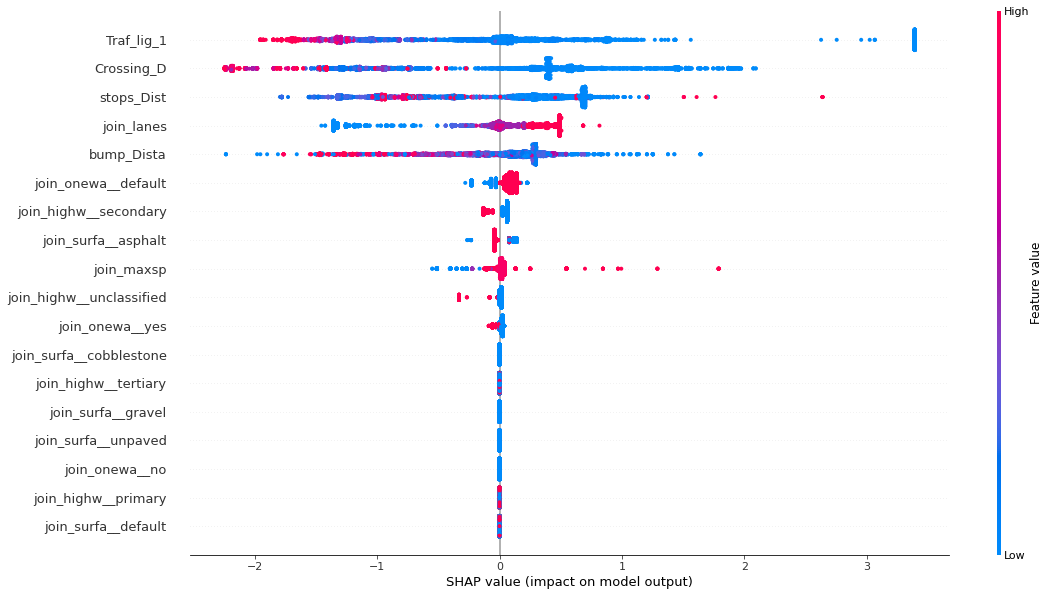

In [65]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_size=[17,10], show=False, )

import matplotlib.pyplot as pl
pl.savefig(os.path.join('results', "VN_shap_summary_plot.jpg"))

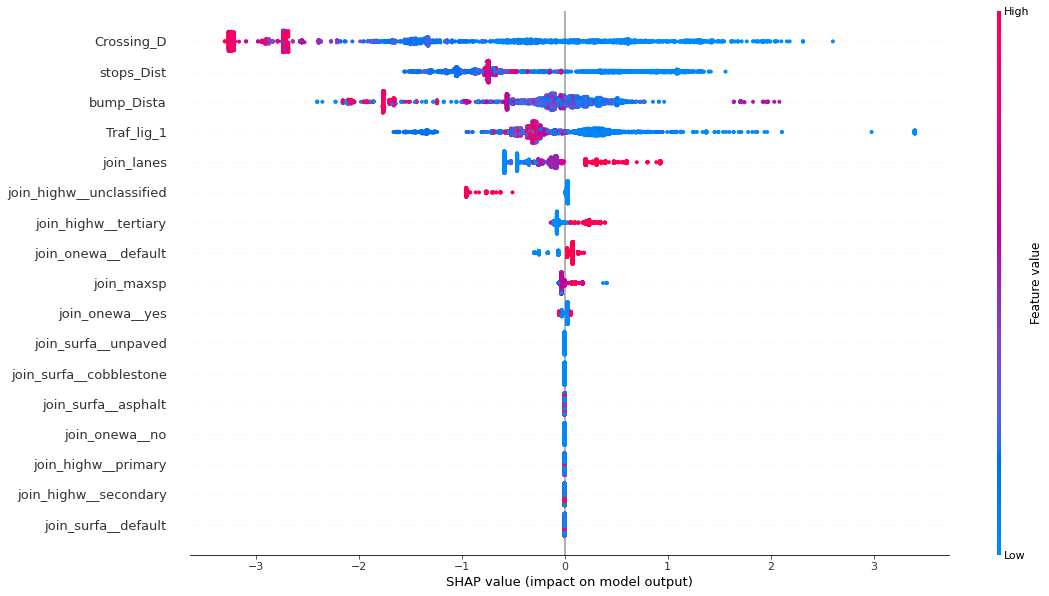

In [35]:
#With just injures
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_size=[17,10], show=False, )

import matplotlib.pyplot as pl
pl.savefig(os.path.join('results', "VN_shap_summary_plot.jpg"))